# Ranking mutations by transmissibility

This assumes you've acquired GISAID data and run
```sh
make update               # ~15 minutes on CPU
python rank_mutations.py  # ~10 minutes on GPU
```

In [1]:
import math
import pickle
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.distributions import constraints
from pyrocov import pangolin

matplotlib.rcParams['figure.dpi'] = 200

## Loading data

In [2]:
aa_features = torch.load("results/nextclade.features.pt")
print(aa_features.keys())

dict_keys(['lineages', 'mutations', 'features'])


In [3]:
rank_results = torch.load("results/rank_mutations.pt", map_location="cpu")
print(rank_results.keys())

dict_keys(['args', 'initial_ranks', 'losses', 'concentrations', 'log_likelihood', 'log_rate_coef'])


## Assessing model accuracy

The inference approach in `rank_mutations.py` is to:
1. Fit a mean-field variational model via stochastic variational inference (SVI).
2. Initially rank mutations by `|mean|/stddev` of their growth rate coefficietns `log_rate_coef`.
3. Fit MAP model parameters via (SVI).
4. For each of most postitive and most negative mutations, fit MAP model parameters with that feature removed.
5. Rank features by the change in loss for base-model versus model-with-feature-removed.

Let's examine the initial versus final ranking metric.

In [4]:
log_rate_coef = rank_results["log_rate_coef"]
initial_ranks = rank_results["initial_ranks"]
feature_ids = torch.tensor(list(rank_results["log_likelihood"].keys()))
log_likelihood = torch.tensor(list(rank_results["log_likelihood"].values()))
concentration = torch.tensor([
    rank_results["concentrations"][k] - rank_results["concentrations"][None]
    for k in rank_results["log_likelihood"]])
log_rate_coef = log_rate_coef[feature_ids]
mean = initial_ranks["mean"][feature_ids]
sigma = mean / initial_ranks["std"][feature_ids]

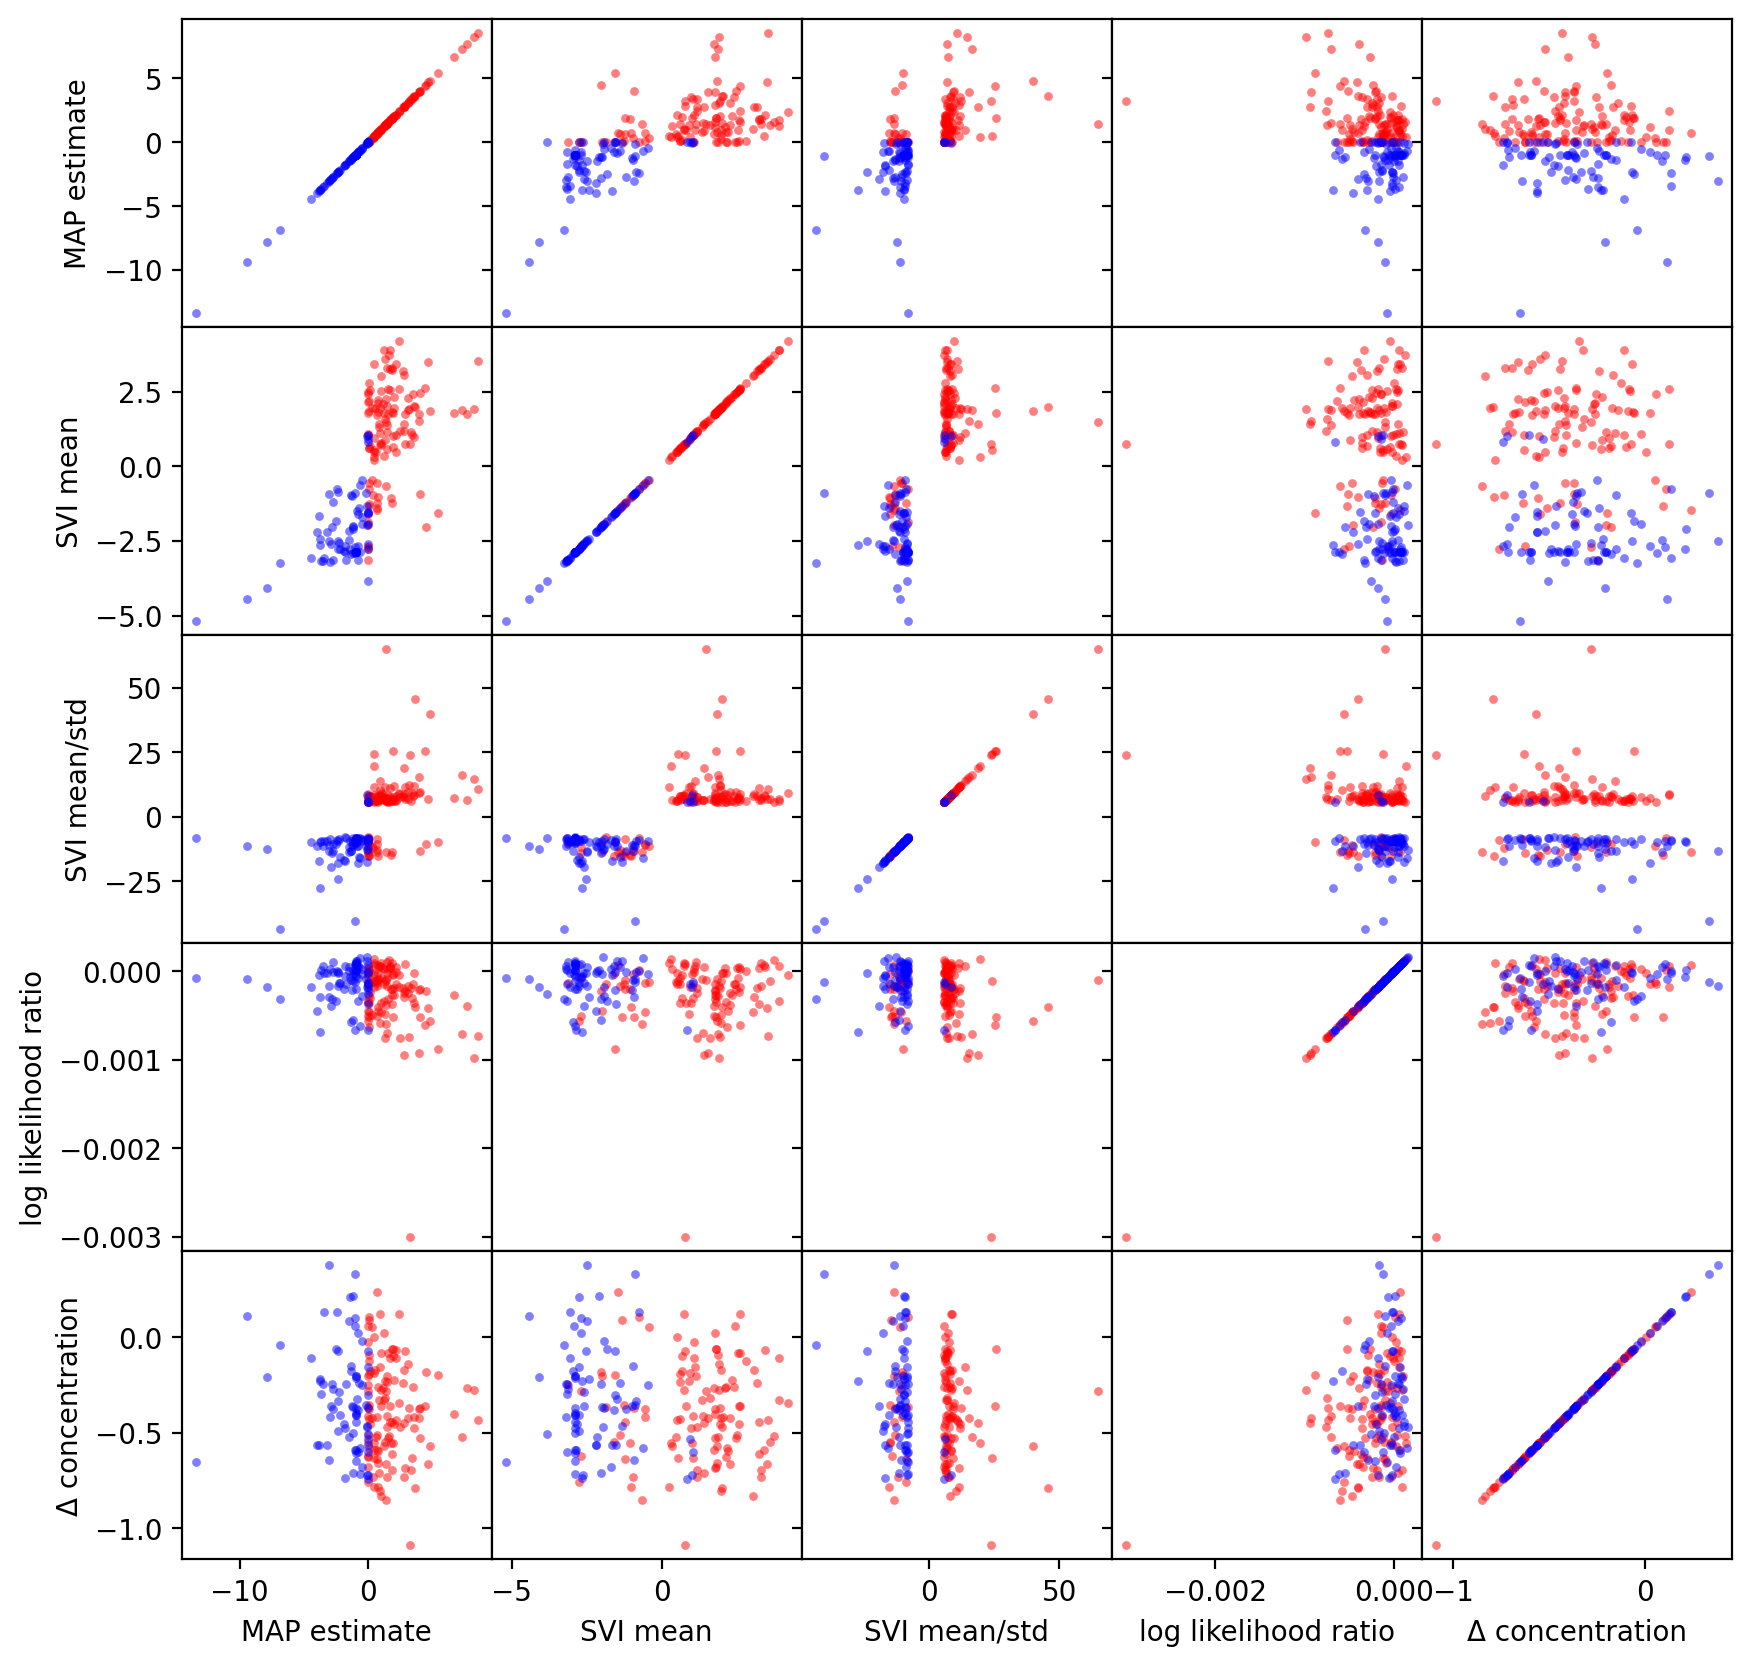

In [5]:
trends = {
    "MAP estimate": log_rate_coef,
    "SVI mean": mean,
    "SVI mean/std": sigma,
    "log likelihood ratio": log_likelihood,
    "Δ concentration": concentration,
}
pos = log_rate_coef > 0
fig, axes = plt.subplots(len(trends), len(trends), figsize=(10, 10), sharex="col", sharey="row")
for i, (axes_i, (name_i, trend_i)) in enumerate(zip(axes, trends.items())):
    axes[i][0].set_ylabel(name_i)
    axes[-1][i].set_xlabel(name_i)
    for j, (ax, (name_j, trend_j)) in enumerate(zip(axes_i, trends.items())):
        ax.scatter(trend_j[pos].numpy(), trend_i[pos].numpy(),
                   10, color='red', alpha=0.5, lw=0)
        ax.scatter(trend_j[~pos].numpy(), trend_i[~pos].numpy(),
                   10, color='blue', alpha=0.5, lw=0)
plt.subplots_adjust(wspace=0, hspace=0)